In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Pre processamento dos dados
#Descrição do dataset

df = pd.read_parquet('../../data/raw/dataset_kobe_dev.parquet')

print("Quantidade de Linhas e Colunas:", df.shape)

data_filtered = df[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']]

print("\nTipos de Campos:\n", data_filtered.dtypes)

categories = ['playoffs', 'shot_made_flag']
print("\nVariáveis Categóricas:", categories)


df.head(), df.shape

Quantidade de Linhas e Colunas: (24271, 25)

Tipos de Campos:
 lat                  float64
lon                  float64
minutes_remaining      int64
period                 int64
playoffs               int64
shot_distance          int64
shot_made_flag       float64
dtype: object

Variáveis Categóricas: ['playoffs', 'shot_made_flag']


(         action_type combined_shot_type  game_event_id   game_id      lat  \
 0          Jump Shot          Jump Shot             10  20000012  33.9723   
 1          Jump Shot          Jump Shot             12  20000012  34.0443   
 2          Jump Shot          Jump Shot             35  20000012  33.9093   
 3          Jump Shot          Jump Shot             43  20000012  33.8693   
 4  Driving Dunk Shot               Dunk            155  20000012  34.0443   
 
    loc_x  loc_y       lon  minutes_remaining  period  ...       shot_type  \
 0    167     72 -118.1028                 10       1  ...  2PT Field Goal   
 1   -157      0 -118.4268                 10       1  ...  2PT Field Goal   
 2   -101    135 -118.3708                  7       1  ...  2PT Field Goal   
 3    138    175 -118.1318                  6       1  ...  2PT Field Goal   
 4      0      0 -118.2698                  6       2  ...  2PT Field Goal   
 
           shot_zone_area  shot_zone_basic  shot_zone_range 

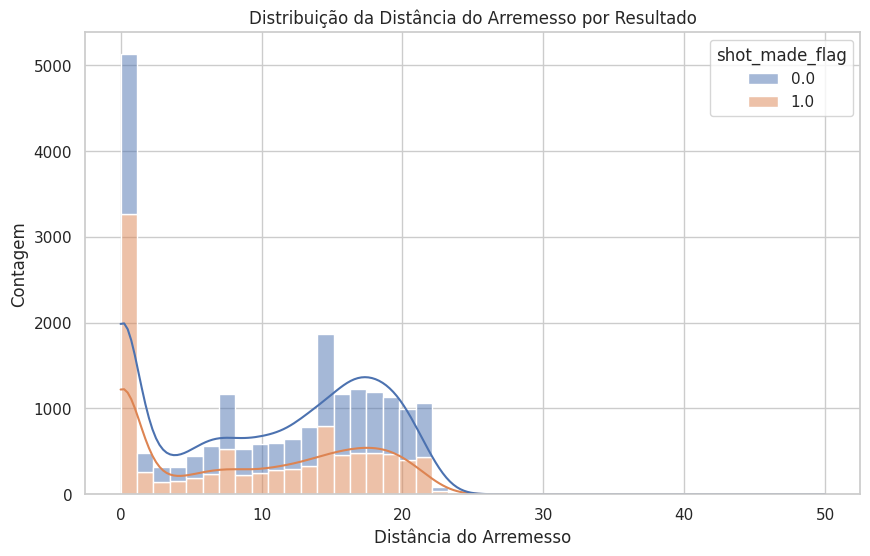

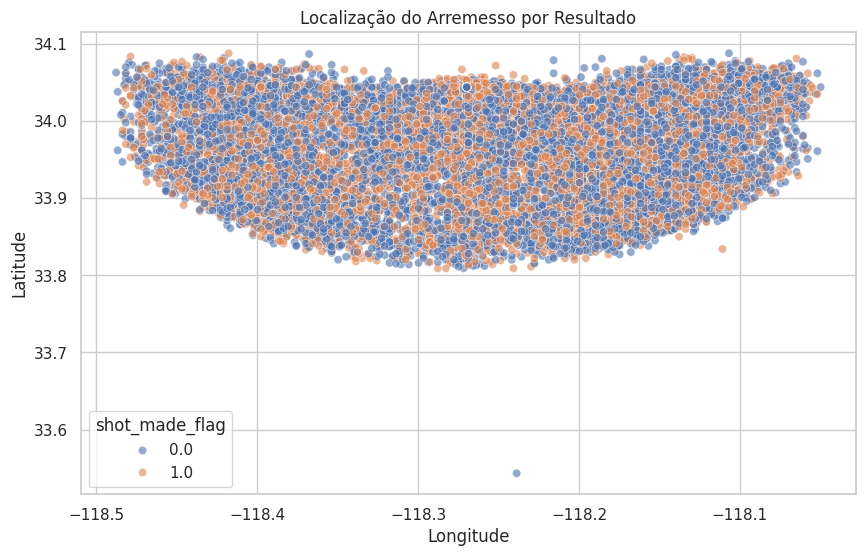

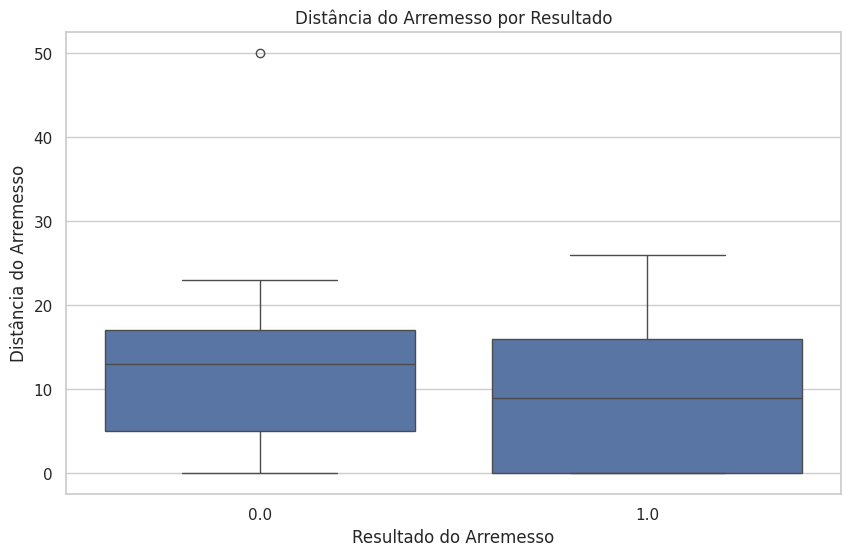

In [3]:
##Pre processamento dos dados
#Análise Exploratória

# Definição do tema dos gráficos
sns.set(style="whitegrid")

# Histograma/Densidade da Distância do Arremesso por Acerto ou Erro
plt.figure(figsize=(10, 6))
sns.histplot(data=data_filtered, x='shot_distance', hue='shot_made_flag', multiple='stack', kde=True)
plt.title('Distribuição da Distância do Arremesso por Resultado')
plt.xlabel('Distância do Arremesso')
plt.ylabel('Contagem')
plt.show()

# Gráfico de dispersão da localização do arremesso (lat x lon), colorido por acerto ou erro
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_filtered, x='lon', y='lat', hue='shot_made_flag', alpha=0.6)
plt.title('Localização do Arremesso por Resultado')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Boxplot da distância do arremesso por resultado
plt.figure(figsize=(10, 6))
sns.boxplot(x='shot_made_flag', y='shot_distance', data=data_filtered)
plt.title('Distância do Arremesso por Resultado')
plt.xlabel('Resultado do Arremesso')
plt.ylabel('Distância do Arremesso')
plt.show()

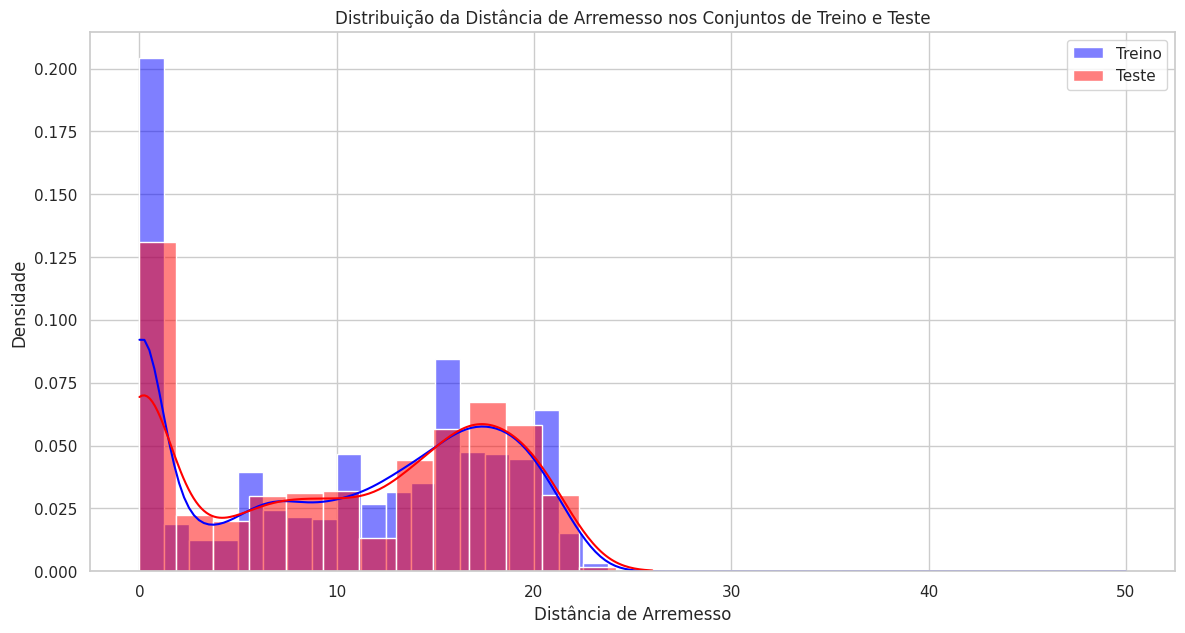

In [4]:
##Pre processamento dos dados
#Seleção base de teste

data_filtered = data_filtered.dropna()

X = data_filtered.drop('shot_made_flag', axis=1)
y = data_filtered['shot_made_flag']

# Dividindo os dados em conjuntos de treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Plot para a distribuição da distância de arremesso nos conjuntos de treino e teste
plt.figure(figsize=(14, 7))

# Treino
sns.histplot(X_train['shot_distance'], color='blue', label='Treino', kde=True, stat='density', alpha=0.5)

# Teste
sns.histplot(X_test['shot_distance'], color='red', label='Teste', kde=True, stat='density', alpha=0.5)

plt.title('Distribuição da Distância de Arremesso nos Conjuntos de Treino e Teste')
plt.xlabel('Distância de Arremesso')
plt.ylabel('Densidade')
plt.legend()
plt.show()

In [5]:
mlflow.set_tracking_uri("sqlite:///../mlruns.db")

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

2024/04/06 17:02:39 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/04/06 17:02:39 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [6]:
train_perc = 0.8

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    dev_data = pd.read_parquet('../../data/raw/dataset_kobe_dev.parquet')

    dev_data.head()

    print('Dimensão do dataset:', dev_data.shape)   
        
    columns = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
    filtered_data = dev_data[columns].dropna()
        
    print('Dimensão do dataset filtrado:', filtered_data.shape)   

    filtered_data.to_parquet('../../data/processed/data_filtered.parquet')

    X = filtered_data.drop('shot_made_flag', axis=1)
    y = filtered_data['shot_made_flag']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_perc, stratify=y, random_state=42)

    X_train.join(y_train).to_parquet("../../data/processed/base_train.parquet")
    X_test.join(y_test).to_parquet("../../data/processed/base_test.parquet")
    
    mlflow.log_params({
        'perc-teste': 1-train_perc,
        'colunas-selecionadas': columns
        })
    mlflow.log_metrics({
        'qtd_linhas_treino': X_train.shape[0],
        'qtd_linhas_teste': X_test.shape[0]
        })
 

Dimensão do dataset: (24271, 25)
Dimensão do dataset filtrado: (20285, 7)
